In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, ttest_ind
from datetime import datetime
import os
import scipy

In [3]:
titlesize = 16
labelsize = 16
legendsize = 16
xticksize = 16
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (10, 6)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

# 2. Размер выборки (sample size)

Вспомним функцию для оценки размера выборки:

$$n > \dfrac{\left[ \Phi^{-1} \Bigl( 1-\dfrac{\alpha}{2} \Bigr) + \Phi^{-1} \Bigl( 1-\beta \Bigr) \right]^2 (\sigma_X^2 + \sigma_Y^2)}{\varepsilon^2}$$

Реализуем эту формулу для случая равных дисперсий:

In [4]:
def get_sample_size_abs(epsilon, std, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

Давайте зафиксируем все параметры кроме дисперсии и построим зависимость sample_size(variance). Мы видим, что зависимость линейная, то есть если мы уменьшаем дисперсию в 4 раза, то требуемый объем данных также уменьшается в 4 раза

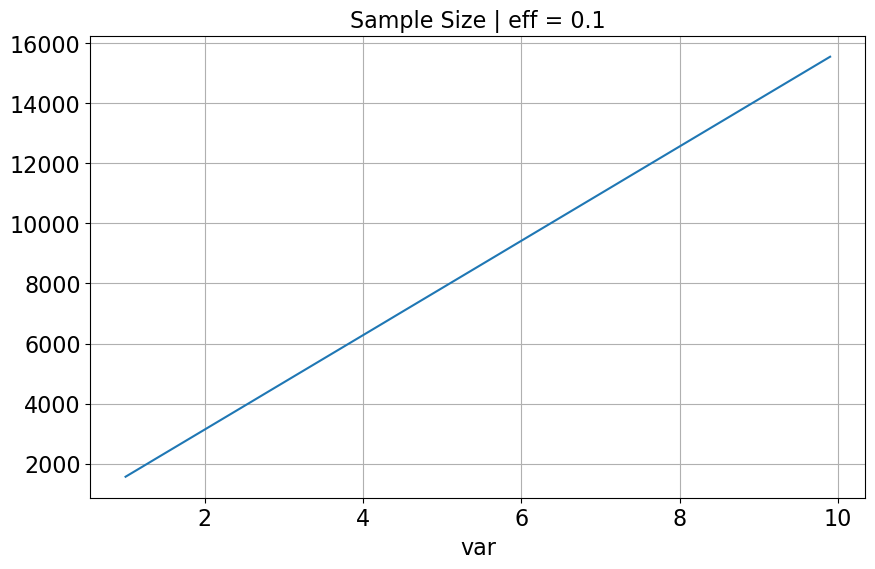

In [5]:
alpha = 0.05
beta = 0.2
eff = 0.1

variances = np.linspace(1, 9.9, 50)
sample_sizes = [
    get_sample_size_abs(eff, var**0.5, alpha, beta) for var in variances
]

plt.title(f'Sample Size | eff = {eff}')
plt.xlabel('var')
plt.plot(variances, sample_sizes)
plt.grid()
plt.show()

# MDE

Напишем функцию для оценки размера выборки

$$\varepsilon > \frac{\left[ \Phi^{-1} \left( 1-\dfrac{\alpha}{2} \right) + \Phi^{-1} \left( 1-\beta \right) \right] \sqrt{ \sigma_X^2 + \sigma_Y^2 }}{\sqrt{n}}$$

Реализуем эту формулу для случая равных дисперсий:

In [6]:
def get_minimal_determinable_effect(std, sample_size, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    disp_sum_sqrt = (2 * (std ** 2)) ** 0.5
    mde = (t_alpha + t_beta) * disp_sum_sqrt / np.sqrt(sample_size)
    return mde

Давайте зафиксируем все параметры кроме дисперсии и построим зависимость MDE(variance). Мы видим, что зависимость обратно квадратичная, то есть если мы уменьшаем дисперсию в 4 раза, эффект, который мы можем обнаружить, уменьшится всего в 2 раза

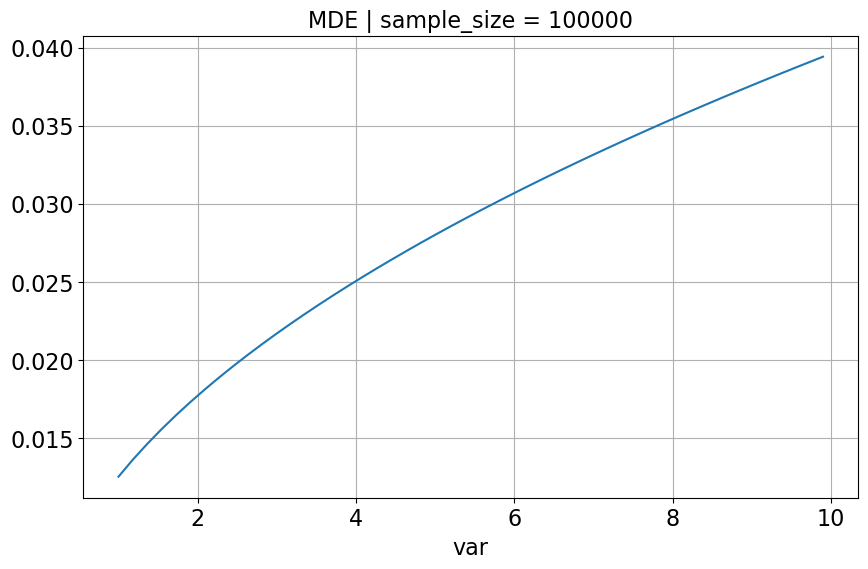

In [7]:
alpha = 0.05
beta = 0.2
sample_size = 100 * 1000

variances = np.linspace(1, 9.9, 50)

mdes = [
    get_minimal_determinable_effect(var**0.5, sample_size, alpha, beta) for var in variances
]

plt.title(f'MDE | sample_size = {sample_size}', )
plt.xlabel('var')
plt.plot(variances, mdes)
plt.grid()
plt.show()

## Mann–Whitney тест
**Вариационный ряд** — последовательность, полученная в результате расположения объектов исходной выборки в порядке от меньшего значения к большему.

Пример. Представьте, что мы собрали 5 человек и измерили их рост:
1. Катя — 163 см
2. Дима — 185 см
3. Лёша — 172 см
4. Маша — 155 см
5. Вика — 180 см
Расположив их по росту от наименьшего к наибольшему, мы получаем тот самый вариационный ряд: \[Маша, Катя, Лёша, Вика, Дима\]. Каждому из них мы можем сопоставить номер в этом ряду.

Кроме теста Стьюдента можно рассматривать и другие статистические критерии. Например, использовать  **ранговые тесты** — тесты, основанные на номерах объектов в вариационном ряду.  Так, если мы хотим сравнить юношей и девушек из предыдущего примера, то группа девушек получает ранги \[1, 2, 4\], а группа юношей получает ранги \[3, 5\].

Примером рангового теста служит критерий Манна-Уитни. Отметим, что критерий Манна-Уитни проверяет иную гипотезу, чем тест Стьюдента. Если тест Стьюдента сравнивает значения средних величин, то критерий Манна-Уитни тестирует гипотезу того, что случайно выбранный объект из первой группы будет с равными шансами как больше, так и меньше случайно выбранного объекта из второй группы. Гипотеза тестируется против альтернативы, что вероятность того, что объект из первой группы больше объекта из второй группы не равна 0.5.

$H\_0: F_X(x) = F_Y(x)$

$H\_1: F_X(x) = F_Y(x + δ), \delta \neq 0$

Если данные приходят из несимметричных распределений, то мы можем получать «неожиданные» результаты при сравнении теста Стьюдента и теста Манна-Уитни. Давайте в качестве примера выберем два логнормальных распределения:

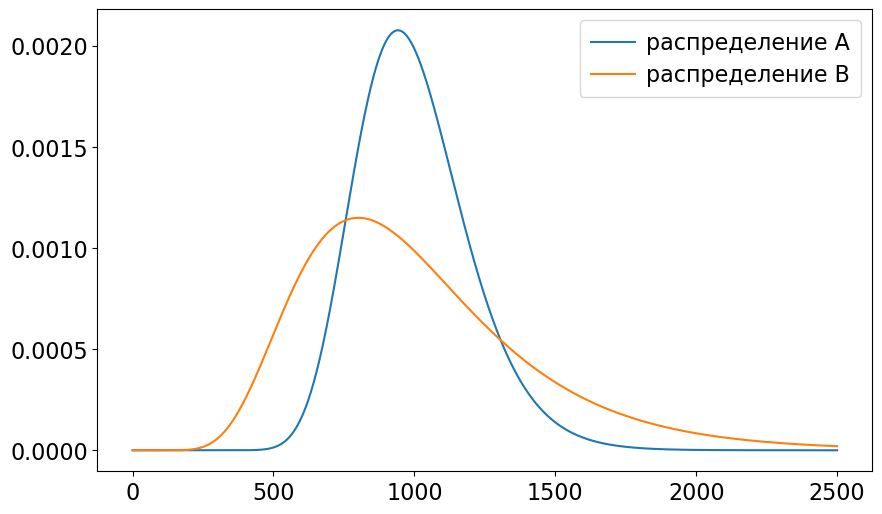

In [9]:
dist_A = scipy.stats.lognorm(s=0.2, scale=980)
dist_B = scipy.stats.lognorm(s=0.4, scale=940)

x = np.linspace(0, 2500, 1000)
plt.plot(x, dist_A.pdf(x), label='распределение A')
plt.plot(x, dist_B.pdf(x), label='распределение B')
plt.legend()
plt.show()

Мы можем сгенерировать две выборки из этих распределений и посмотреть на результаты тестов.

In [10]:
np.random.seed(0)
size = 1000


A = dist_A.rvs(size)
B = dist_B.rvs(size)


print(scipy.stats.ttest_ind(A, B, equal_var=False, alternative='less'))
print(scipy.stats.mannwhitneyu(A, B, alternative='greater'))

TtestResult(statistic=-1.9943490321454433, pvalue=0.02315133457678808, df=1436.3583518671237)
MannwhitneyuResult(statistic=526446.0, pvalue=0.020282562200870446)


Обратите внимание, что оба раза мы получаем значимый результат на уровне ниже 5%. Но при этом тест Стьюдента говорит, что первая выборка значимо меньше, а тест Манна-Уитни сообщает нам, что первая выборка значимо больше! И в этом нет никакого обмана. Среднее значение в первой выборке на самом деле меньше. Но при этом взятый наугад элемент из первой выборки чаще оказывается больше, чем случайно выбранный элемент из второй группы.

Важно отметить, что критерий Манна-Уитни намного устойчивей к выбросам, чем критерий Стьюдента. В силу того, что единичный выброс (сколь бы большой величины он не был) влияет только на взаимное расположение объектов с «битым» экземпляром. В то же время для критерия Стьюдента отдельный выброс может значительно сместить среднее значение, то есть влияние оказывается на всю выборку, и это влияние тем больше, чем больше величина выброса.

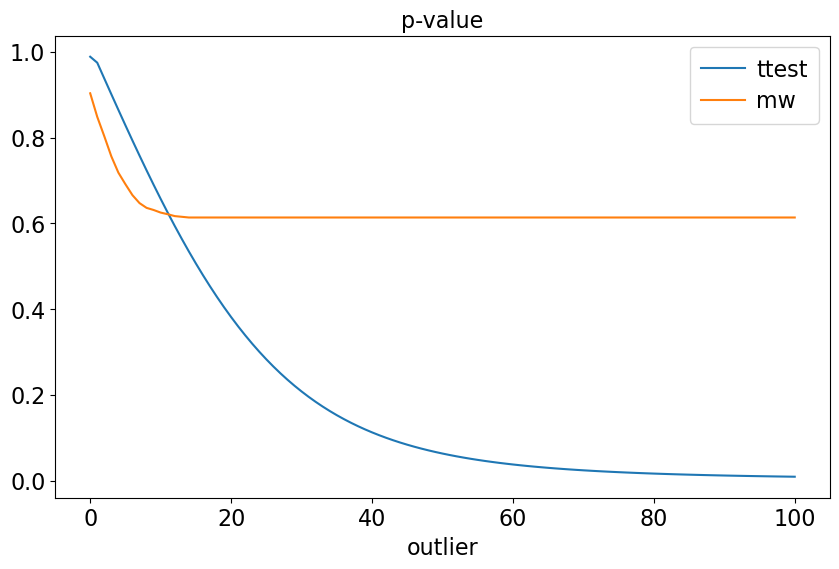

In [11]:
outliers = np.linspace(0, 20, 101)

tt_pvals = []
mw_pvals = []
for outlier in outliers:
    np.random.seed(10)
    x = np.random.normal(0, 1, 1000)
    y = np.random.normal(0, 1, 1000)
    y[:10] = outlier

    tt_pvals.append(ttest_ind(x, y, equal_var=False)[1])
    mw_pvals.append(scipy.stats.mannwhitneyu(x, y, alternative='two-sided')[1])

plt.plot(tt_pvals, label='ttest')
plt.plot(mw_pvals, label='mw')
plt.xlabel('outlier')
plt.title('p-value')
plt.legend()
plt.show()

Mann–Whitney тест
1. не проверяет равенство средних
2. не проверяет равенство медиан

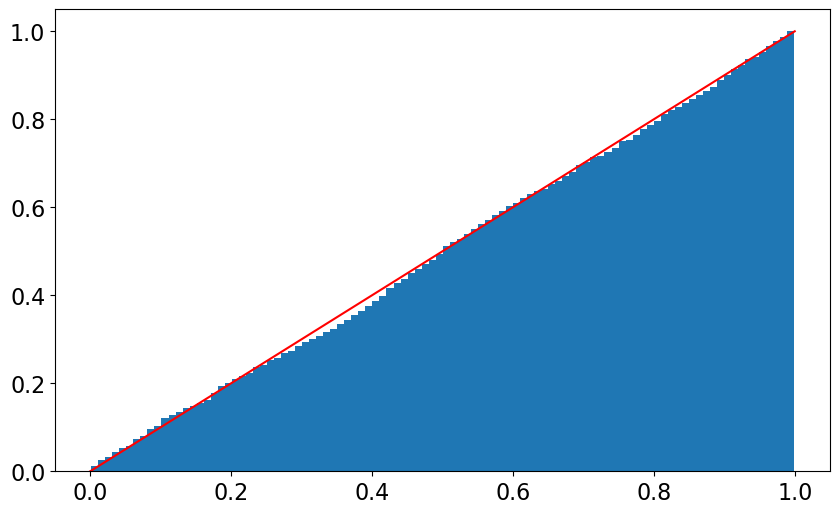

In [17]:
p_values = []
for _ in range(1000):
    a = np.random.normal(0, 100, 100)
    b = np.random.normal(0, 10, 1000)
    #p_values.append(stats.mannwhitneyu(a, b, alternative='two-sided').pvalue)
    p_values.append(stats.ttest_ind(a, b, equal_var=False).pvalue)

plt.hist(p_values, bins=100, cumulative=True, density=True);
plt.plot([0, 1], [0, 1], color='r')

# Выбросы

Давайте посмотрим, как различные статитические тесты могут реагировать на выбросы. Для этого многократно проведем процедуру А/А и А/Б тестирования на синтетических данных, предварительно заменив некоторый объем данных выбросами

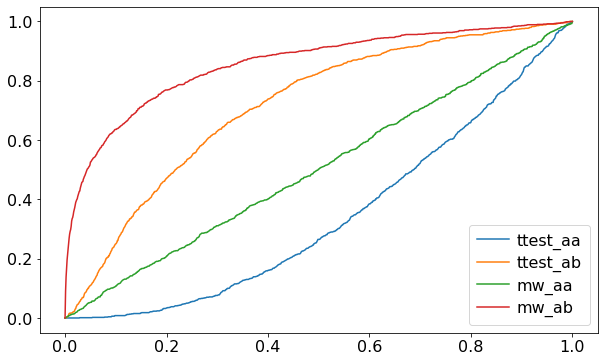

In [11]:
sample_size = 100
effect = 3

pvalues = {'ttest_aa': [], 'ttest_ab': [], 'mw_aa': [], 'mw_ab': [], }

for _ in range(1000):
    a1 = np.random.normal(100, 10, sample_size)
    a2 = np.random.normal(100, 10, sample_size)
    b = np.random.normal(100 + effect, 10, sample_size)

    a1[:2] = 200
    a2[:2] = 200
    b[:2] = 200

    pvalues['ttest_aa'].append(stats.ttest_ind(a1, a2).pvalue)
    pvalues['ttest_ab'].append(stats.ttest_ind(a1, b).pvalue)
    pvalues['mw_aa'].append(stats.mannwhitneyu(a1, a2, alternative='two-sided').pvalue)
    pvalues['mw_ab'].append(stats.mannwhitneyu(a1, b, alternative='two-sided').pvalue)
    

X = np.linspace(0, 1, 1000)
for key, values in pvalues.items():
    values = np.array(values)
    Y = [np.mean(values < x) for x in X]
    plt.plot(X, Y, label=key)

plt.legend()
plt.show()

# Данные пиццерии

In [12]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

In [13]:
web_logs = read_database('2022-04-01T12_df_web_logs.csv')
web_logs['date'] = pd.to_datetime(web_logs['date'])
web_logs.head(3)

,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7


web-logs — таблица с логами посещения сайта.

1. user_id — идентификатор пользователя;
2. page — какая страница сайта была открыта. Типы страниц:
    + m — страница с меню;
    + b  — страница с корзиной и подтверждением заказа;
    + p — страница с оплатой заказа;
3. date — дата открытия страницы;
4. load_time — время загрузки страницы в миллисекундах.

**Предполагается, что данные независимы**

Давайте проведем анализ, сколько данных нам потребуется, если мы захотим проводить тест в течение недели, если мы хотим быть способны обнаружить эффект в 1%

In [14]:
web_logs_hist = web_logs[
    (web_logs['date'] >= datetime(2022, 3, 22))
    & (web_logs['date'] < datetime(2022, 3, 29))
]
web_logs_hist.shape

(247163, 4)

In [15]:
alpha = 0.05
beta = 0.2

mean = web_logs_hist['load_time'].mean()
std = web_logs_hist['load_time'].std()

eff = mean * 0.01
print(f"var is {std ** 2}")

var is 12447.803325889607


In [16]:
sample_size = get_sample_size_abs(eff, std, alpha=alpha, beta=beta)
print(f'sample_size = {sample_size}')

sample_size = 355889


Нам требуется более 350 000 наблюдений, связанных с загрузкой страницы. Можно ли оценить такой же эффект, но с меньшими затратами? Давайте посмотрим на распределение выборки

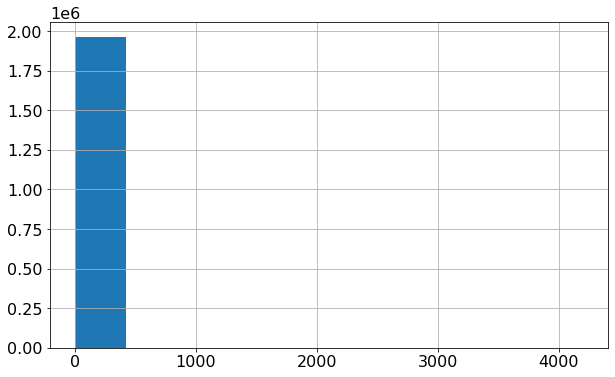

In [17]:
web_logs['load_time'].hist()

Мы видим, что бОльшая часть данных находится около нуля, но при этом есть огромные выбросы, которые могут сильно влиять на дисперсию данных. Давайте попробуем удалить выбросы и повторить оценку дизайна эксперимента

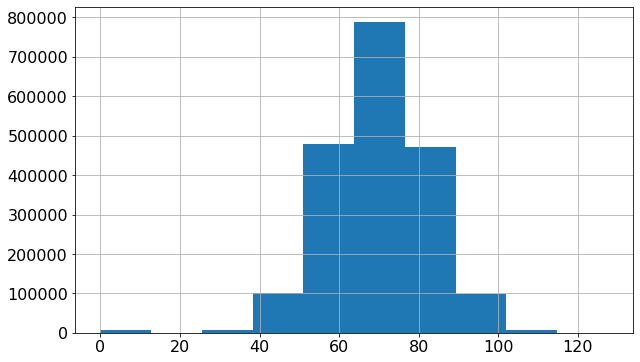

In [18]:
web_logs_filtered = web_logs[web_logs['load_time'] < 1000] 
web_logs_filtered['load_time'].hist()

In [19]:
alpha = 0.05
beta = 0.2

std = web_logs_filtered['load_time'].std()
print(f"var is {std ** 2}")

var is 162.03326010465977


In [20]:
sample_size = get_sample_size_abs(eff, std, alpha=alpha, beta=beta)
print(f'sample_size = {sample_size}')

sample_size = 4633


Дисперсия упала более чем в 76 раз, что привело к падению необходимого размера выборки в 76 раз. Таким образом даже такие простые методы, как фильтрация выбросов может приводить к существенному снижению дисперсии при условии, что данная процедура значительно снижает дисперсию